**The purpose of this notebook is to test the data preparation against the ground truth.**

This notebook is not needed for predicting user behaviours.

In [1]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse import csc_matrix as csc
import pandas as pd
pd.options.display.float_format = '{:,.6f}'.format
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    explained_variance_score,
    roc_auc_score,
    log_loss,
    confusion_matrix
)
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
FONT_SIZE = 24
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = FONT_SIZE
plt.rcParams['legend.fontsize'] = FONT_SIZE
plt.rcParams['xtick.labelsize'] = FONT_SIZE
plt.rcParams['ytick.labelsize'] = FONT_SIZE
%config InlineBackend.figure_format ='retina'
import itertools
from constants import (SEED, EPSILON, EVENT_THRESHOLD, DEFAULT_K, DEFAULT_THRESHOLD, LOG_DIR, UX_CONSTANTS,
                       DATA_DIR, TEST_DATA_PATH, DATA_OCT, DATA_NOV, USECOLS, USER, ITEM, RATING, PREDICTION)
from utilities.ms_evaluation import (rmse, auc, logloss, precision_at_k, recall_at_k, ndcg_at_k, map_at_k, mae, rsquared, exp_var)

In [2]:
TEST_RESULTS_PATH = DATA_DIR+'\\data-preparation-test-results.csv'
MSE = "(calculated using the Microsoft Evaluation method)"
ux_constants = pd.Series(pd.read_csv(UX_CONSTANTS, index_col=0, squeeze=True, header=None), dtype='float32')
POSITIVE_ABOVE = ux_constants['positive_above']

In [3]:
### NOTE: the y_hat from this test will serve as y in testing the machine learning models
### For our purposes (accessing elements of the sparse matrix) DOK is the fastest format
log = pd.Series(dtype='float64')
y_hat = sp.load_npz(TEST_DATA_PATH) # use this to test the data preparation, 
y_hat = y_hat.todok()
print(f"Number of non-zero values: {y_hat.nnz:8,}")

Number of non-zero values:  552,255


# Test data preparation y against ground truth purchases events

In [4]:
input_df = pd.concat([pd.read_csv(DATA_OCT, engine='c', sep=',',usecols=USECOLS)
                ,pd.read_csv(DATA_NOV, engine='c', sep=',',usecols=USECOLS)])
drop_visitors = set(input_df.user_id.value_counts()[input_df.user_id.value_counts()<EVENT_THRESHOLD].index)
input_df = input_df[~input_df.user_id.isin(drop_visitors)]
input_df.reset_index(inplace=True,drop=True)
new_user_id = pd.Series(pd.read_csv(DATA_DIR+r'new_user_id.csv', index_col=1, squeeze=True), dtype='int32')
new_product_id = pd.Series(pd.read_csv(DATA_DIR+r'new_product_id.csv', index_col=1, squeeze=True), dtype='int32')
input_df = input_df[input_df.event_type=='purchase']
input_df = input_df.drop(columns=['event_type'])
purchases = set()

for row in input_df.itertuples(): 
    uid = new_user_id[row.user_id]
    pid = new_product_id[row.product_id]
    purchases.add((uid,pid))    
print(f"Number of purchase events in test the dataset: {len(purchases)}")

Number of purchase events in test the dataset: 547912


In [5]:
df_true = []
rows,cols = y_hat.nonzero()
for row,col in zip(rows,cols):
    if (row,col) in purchases:
        df_true.append([row,col,1])
    else:
        df_true.append([row,col,0])
df_true = pd.DataFrame(data=df_true,columns=[USER, ITEM, RATING])
df_true.head(1)

,userID,itemID,rating
0,0,0,1


In [6]:
df_prepared = []
rows,cols = y_hat.nonzero()
for row,col in zip(rows,cols):
    if y_hat[row,col] > POSITIVE_ABOVE:
        df_prepared.append([row,col,1])
    else:
        df_prepared.append([row,col,0])  
#     df_prepared.append([row,col,y_hat[row,col]])
df_prepared = pd.DataFrame(data=df_prepared,columns=[USER, ITEM, PREDICTION])
df_prepared.head(1)  

,userID,itemID,prediction
0,0,0,1


# Standard metrics

### Root Mean Square Error

In [7]:
rmse_mse = rmse(df_true,df_prepared)
print(f"Root Mean Square Error: {rmse_mse} {MSE}")
print('Note: The smaller the better.')
log["rmse"]=rmse_mse

Root Mean Square Error: 0.06022414545897269 (calculated using the Microsoft Evaluation method)
Note: The smaller the better.


### Mean Absolute Error

In [8]:
mae_mse = mae(df_true,df_prepared)
print(f"Mean Absolute Error: {mae_mse} {MSE}")
print('Note: The smaller the better.')
log["mae"]=mae_mse

Mean Absolute Error: 0.0036269476962635014 (calculated using the Microsoft Evaluation method)
Note: The smaller the better.


### R²

In [9]:
r2_mse = rsquared(df_true,df_prepared)
print(f"Coefficient of determination (R\u00B2): {r2_mse} {MSE}")
print("Note: The closer to 1 the better.")
log["r-squared"]=r2_mse

Coefficient of determination (R²): 0.9713705377724504 (calculated using the Microsoft Evaluation method)
Note: The closer to 1 the better.


### Explained variance

In [10]:
exp_var_mse = exp_var(df_true,df_prepared)
print(f"Explained variance: {exp_var_mse} {MSE}")
print("Note: The closer to 1 the better.")
log["exp_var"]=exp_var_mse

Explained variance: 0.9713896353776997 (calculated using the Microsoft Evaluation method)
Note: The closer to 1 the better.


### Arear Under Curve (AUC) - integral area under the receiver operating characteristic curve


In [11]:
auc_mse = auc(df_true,df_prepared)
print(f"Arear Under Curve (AUC): {auc_mse} {MSE}")
print("Note: The closer to 1 the better. 0.5 indicates an uninformative classifier")
log["auc"]=auc_mse

Arear Under Curve (AUC): 0.994998401692711 (calculated using the Microsoft Evaluation method)
Note: The closer to 1 the better. 0.5 indicates an uninformative classifier


### Logistic loss (logloss)

In [12]:
logloss_mse = logloss(df_true,df_prepared)
print(f"Logistic loss (logloss): {logloss_mse} {MSE}")
print("Note: The closer to 0 the better.")
log["logloss"]=logloss_mse

Logistic loss (logloss): 0.12527240738957413 (calculated using the Microsoft Evaluation method)
Note: The closer to 0 the better.


### Precision @ K

In [13]:
precision_at_k_mse = precision_at_k(df_true,df_prepared)
print(f"Precision @ {DEFAULT_K}: {precision_at_k_mse} {MSE}")
print("Note: The closer to 1 the better.")
log[f"precision-at-{DEFAULT_K}"]=precision_at_k_mse

Precision @ 10: 0.34191752705560396 (calculated using the Microsoft Evaluation method)
Note: The closer to 1 the better.


### Recall @ K

In [14]:
recall_at_k_mse = recall_at_k(df_true,df_prepared)
print(f"Recall @ {DEFAULT_K}: {recall_at_k_mse} {MSE}")
print("Note: The closer to 1 the better.")
log[f"recall-at-{DEFAULT_K}"]=recall_at_k_mse

Recall @ 10: 0.9668412602660089 (calculated using the Microsoft Evaluation method)
Note: The closer to 1 the better.


### normalized Discounted Cumulative Gain

In [15]:
ndcg_mse = ndcg_at_k(df_true,df_prepared)
print(f"normalized Discounted Cumulative Gain (nDCG@{DEFAULT_K}): {ndcg_mse} {MSE}")
print("Note: The closer to 1 the better.")
log[f"ndcg-at-{DEFAULT_K}"]=ndcg_mse

normalized Discounted Cumulative Gain (nDCG@10): 1.0 (calculated using the Microsoft Evaluation method)
Note: The closer to 1 the better.


### mAP (mean Average Precision) 

In [16]:
map_mse = map_at_k(df_true,df_prepared)
print(f"mean Average Precision (mAP@{DEFAULT_K}): {map_mse} {MSE}")
print("Note: The closer to 1 the better.")
log[f"map-at-{DEFAULT_K}"]=map_mse

mean Average Precision (mAP@10): 0.9668412602660089 (calculated using the Microsoft Evaluation method)
Note: The closer to 1 the better.


## Confusion matrix

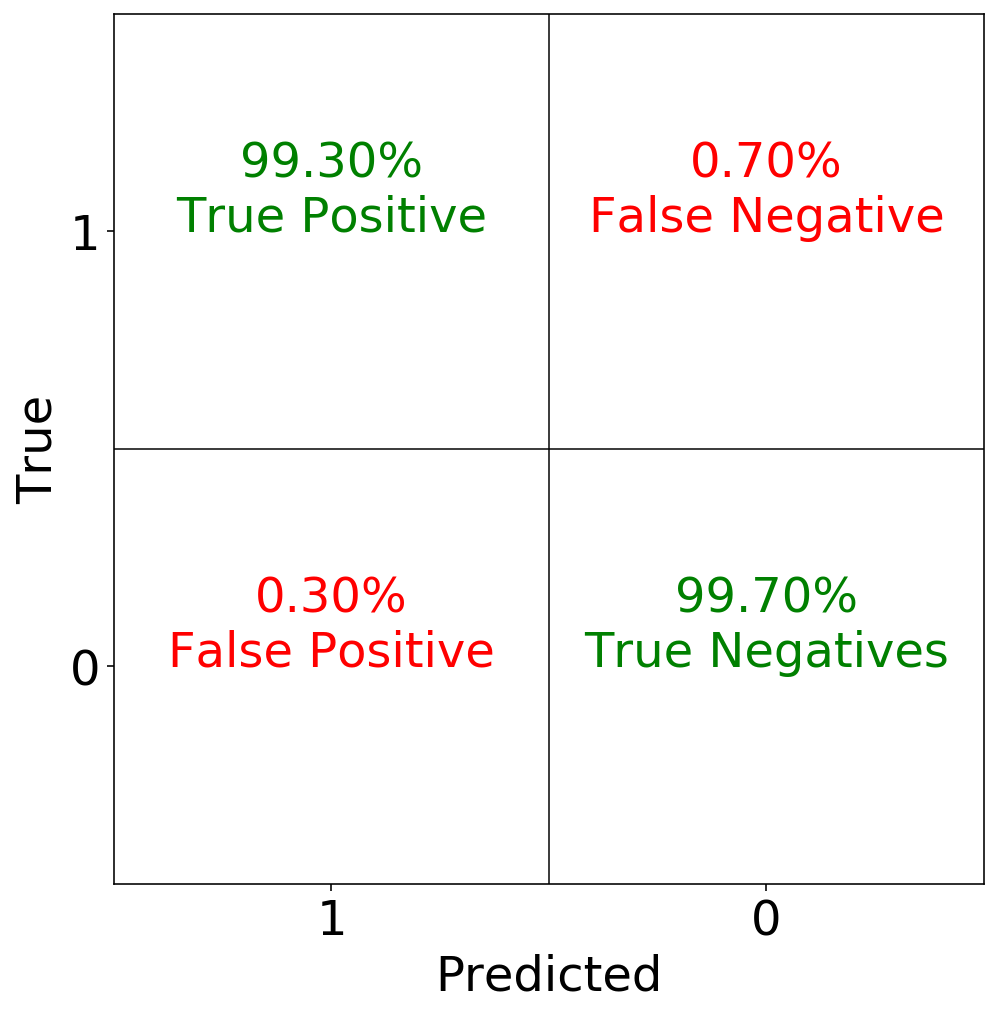

In [17]:
conf_mat = confusion_matrix(
    [1 if x > POSITIVE_ABOVE  else 0 for x in df_true[RATING]],
    [1 if x > POSITIVE_ABOVE  else 0 for x in df_prepared[PREDICTION]],  
    labels=[1,0])
conf_mat = np.round(conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis],4)*100
log["true_positive"]=f"{conf_mat[0,0]:.2f}%"
log["false_negative"]=f"{conf_mat[0,1]:.2f}%"
log["false_positive"]=f"{conf_mat[1,0]:.2f}%"
log["true_negative"]=f"{conf_mat[1,1]:.2f}%"

descriptions = np.array([["True Positive", "False Negative"], ["False Positive", "True Negatives"]])
colors = np.array([["green", "red"], ["red", "green"]])

plt.imshow([[0,0],[0,0]], interpolation='nearest', cmap=plt.cm.Greys)
for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])): 
    plt.text(j, i, format(conf_mat[i, j], ".2f")+'%\n' + descriptions[i, j], horizontalalignment="center", color=colors[i,j])
plt.axhline(y=0.5, xmin=0, xmax=1, color="black", linewidth=0.75)
plt.axvline(x=0.5, ymin=0, ymax=1, color="black", linewidth=0.75)
plt.ylabel('True')
plt.xlabel('Predicted')
# plt.title("Confusion Matrix")
plt.xticks([0,1], [1,0])
plt.yticks([0,1], [1,0])
plt.show()

In [18]:
log.to_csv(TEST_RESULTS_PATH, index = True, header=False)
log

rmse              0.060224
mae               0.003627
r-squared         0.971371
exp_var           0.971390
auc               0.994998
logloss           0.125272
precision-at-10   0.341918
recall-at-10      0.966841
ndcg-at-10        1.000000
map-at-10         0.966841
true_positive       99.30%
false_negative       0.70%
false_positive       0.30%
true_negative       99.70%
dtype: object